Plan:
- [x] Read the article
- [] Repeat it hear
- [] Reread what was written
- [] Integrate article about two fish bites
- [] Do necessary refactoring if needed

Link to the article from habrahabr (in russian): https://habr.com/ru/post/557424/

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams["figure.figsize"] = 10, 6

Let's image that during the whole year we ordered pizza and measured time of delivery each time.

In [76]:
norm_rv = stats.norm(loc=30, scale=5)

In [79]:
np.random.seed(42)
samples = norm_rv.rvs(365)
samples = np.trunc(samples)
samples[:50]

array([32., 29., 33., 37., 28., 28., 37., 33., 27., 32., 27., 27., 31.,
       20., 21., 27., 24., 31., 25., 22., 37., 28., 30., 22., 27., 30.,
       24., 31., 26., 28., 26., 39., 29., 24., 34., 23., 31., 20., 23.,
       30., 33., 30., 29., 28., 22., 26., 27., 35., 31., 21.])

Of course we want to take a look at the min, max, mean and std values.

In [83]:
print(min(samples))
print(max(samples))
print(samples.mean())
print(samples.std())

13.0
49.0
29.52054794520548
4.77410133275075


In other words we can say that average time of delivery is $30 \pm 5$ minutes.

Also it might be interesting to see how values are distributed.

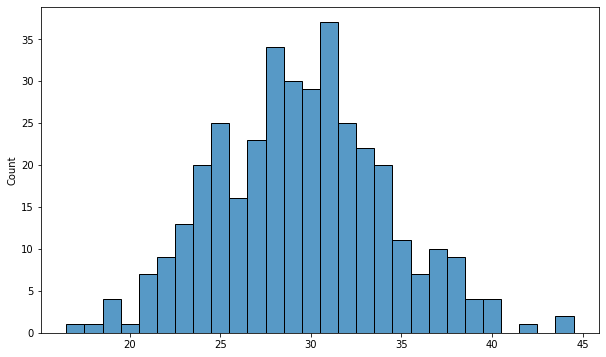

In [15]:
sns.histplot(samples, discrete=True);

By looking at this chart we can easily assume that time delivery can have normal distribution. But why we decided that it has normal distribution? Because this histogram looks similar to normal distribution probability density plot? If we are talking about visual acceptance then we can easily build a chart from other distribution that will look also similar to the histogram above.

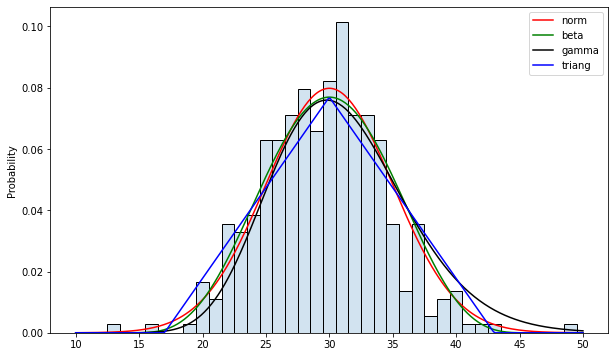

In [84]:
np.random.seed(42)
norm_rv = stats.norm(loc=30, scale=5)
beta_rv = stats.beta(a=5, b=5, loc=14, scale=32)
gamma_rv = stats.gamma(a=20, loc=7, scale=1.2)
tri_rv = stats.triang(c=0.5, loc=17, scale=26)

x = np.linspace(10, 50, 300)

sns.lineplot(x=x, y=norm_rv.pdf(x), color="r", label="norm")
sns.lineplot(x=x, y=beta_rv.pdf(x), color="g", label="beta")
sns.lineplot(x=x, y=gamma_rv.pdf(x), color="k", label="gamma")
sns.lineplot(x=x, y=tri_rv.pdf(x), color="b", label="triang")

sns.histplot(x=samples, discrete=True, stat="probability", alpha=0.2);

Are we sure that the distribution is normal?

The process of delivery might trigger multiple situations:
- wait at the stop sign for the green light
- injured leg so walked slower than usual
- car didn't want to start
- and so on

For us doesn't matter what are these situations, we only care that they are independent and have uniform distribution.

For example take variable $X_{1}$ which describes time spent at the stop sign. It has uniform distribution and ranges from 0 up to 4 minutes.

In [86]:
uniform_rv = stats.uniform(loc=0, scale=4)

In [96]:
np.random.seed(42)
uniform_rv.rvs(size=1)

array([1.49816048])

And tomorrow, after-tomorrow and after-after-tomorrow in might be:

In [95]:
np.random.seed(42)
uniform_rv.rvs(size=3)

array([1.49816048, 3.80285723, 2.92797577])

Now let's imagine that there are 15 of such variables and each introduces it's own value into overall delivery time because such events can be added to each other. 

If you imagined total 15 variables: $X_{1}, X_{2}, ... ,X_{15},$, then we can say that total delivery time consist of sum of these variables and this delivery time is also random variable which we can assign to letter $Y$:

$$ Y = X_{1} + X_{2} + ... + X_{15} = \sum_{i=1}^{15}X_{i} $$

If all variable values ($X_{1}, X_{2}, ... ,X_{15},$) are distributed uniformly then how would be distributed their sum - variable $Y$? 

In order to find out let's generate 10k such sums and take a look at the histogram:

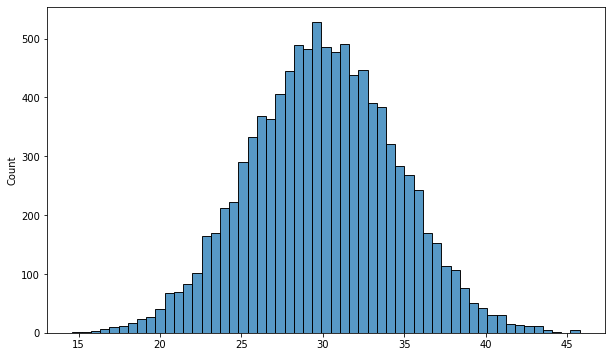

In [97]:
np.random.seed(42)
Y_samples = [uniform_rv.rvs(size=15).sum() for _ in range(10_000)]
sns.histplot(x=Y_samples);

Does this picture remind you the same bell as in normal distribution? If so, then you've just understood central limit theory: distribution of sum of random variables moves towards normal distribution with the increase of the number of variables in that sum.

Of course that example with pizza delivery is not exactly wright as all situations might occur or might not. 

For example time of delivery for today consist of these variables:

$$ Y = X_{3} + X_{5} + X_{7} + X_{11} $$ 

And tomorrow it might be:

$$ Y = X_{1} + X_{3} + X_{9} + X_{10} + X_{13} + X_{15}$$ 

Will be $Y$ distributed normally? Well, considering that sum of normally distributed variables also has normal distribution than we can say yes. This is exactly why when we took a look at the distribution of 365 samples of delivery we almost immediately decided that this is normal distribution despite it doesn't look like perfect bell. 

## Z-values

Imaging that after a year of our measurements we've got a new neighbor and also decided to order pizza daily. After three days we became a victim of an argument between our neighbor and pizza delivery guy. We tried to support delivery guy and said that on average time of delivery is $30 \pm 5$ minutes. Our neighbor said that he order pizza three time and all three times delivery took more than 40 minutes which is definitely longer than 35 minutes.  

Why our neighbor is so confident in long time of deliver? It looks like he thinks that $30 \pm 5$ minutes means that delivery can take 27, 31 or even 35 minutes but not 23 or 38 minutes. But we've ordered pizza 365 times and know that delivery time can take somewhere in between 17 and 44 minutes. And $30 \pm 5$ just means that some major portion of deliveries will take from 25 to 35 minutes. 

Knowing parameters of the distribution we can generate couple of thousands of deliveries and find out the size of that majority delivery portion.

In [103]:
N = 5_000
np.random.seed(42)
t_data = norm_rv.rvs(N)
t_data[(25 < t_data) & (t_data < 35)].size / N

0.6874

Approximately two thirds of all generated deliveries are in range between 25 and 35 minutes. How many deliveries took more than 40 minutes?  

In [112]:
t_data[t_data > 40].size / N

0.0224

It turns out that slightly more than 2 percent of generated deliveries took more than 40 minutes. But our neighbor said that he delivered 3 times in a row and all of them took more than 40 minutes. Maybe our neighbor is extremely unlucky because probability of it is very low: 

In [113]:
0.02**3

8.000000000000001e-06

Of course computer modeling is all good and what not but in this case it's better to use $Z$-values:

$$ Z = \frac{y - \mu}{\sigma} $$

where:
- $y$: delivery time, in other words some exact value from random variable $Y$
- $\mu$: mathematical expectancy
- $\sigma$: standard deviation

So let's calculate $Z$-value for 40 minutes delivery:

$$ Z = \frac{40 - 30}{5} = 2$$

What we have just done? We've just calculated by what value our delivery time differs from average delivery time and then just divided by value of standard deviation. But how to understand the result of this calculation and what does $Z$-value means? 

In order to understand it we need to "draw" a little bit.

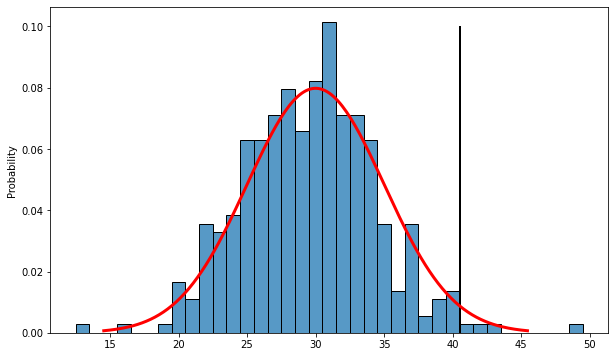

In [114]:
fig, ax = plt.subplots()
x = np.linspace(norm_rv.ppf(0.001), norm_rv.ppf(0.999), 200)
ax.vlines(40.5, 0, 0.1, color="k", lw=2)
sns.lineplot(x=x, y=norm_rv.pdf(x), color="r", lw=3)
sns.histplot(x=samples, stat="probability", discrete=True);

At this chart we plotted histogram from our `samples` data, but now height of each square means not the quantity of each values but probability of it. With red line we plotted function of distribution of probability density of delivery values. 

Above we tried to by experimental approach to decide what portion of measurements take deliveries with time more than 40 minutes. And this chart should give us some thoughts that there are two approaches of solving this task. The first one is experimental, we generate for example 5k deliveries and then build histogram and calculate sum of rectangles that lay to the right from black line: 

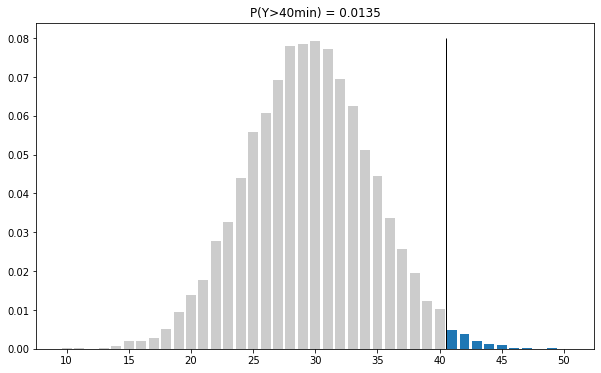

In [115]:
np.random.seed(42)
N = 10000
values = np.trunc(norm_rv.rvs(N))

fig, ax = plt.subplots()
v_le_41 = np.histogram(values, np.arange(9.5, 41.5))
v_ge_40 = np.histogram(values, np.arange(40.5, 51.5))
ax.bar(np.arange(10, 41), v_le_41[0] / N, color="0.8")
ax.bar(np.arange(41, 51), v_ge_40[0] / N)
p = np.sum(v_ge_40[0] / N)
ax.set_title("P(Y>40min) = {:.3}".format(p))
ax.vlines(40.5, 0, 0.08, color="k", lw=1);

The other approach - analytic. As we know that delivery times are from normal distribution then we can use function of distribution of probability density. This function is good because the area underneath it is always equals to 1 and if we are interested in probability of value that is higher or lower of given value we can simply take the are under the function that is to the right or to the left of that given value.

For example we can calculate and plot probability of delivery time that take more than 40 minutes like so:

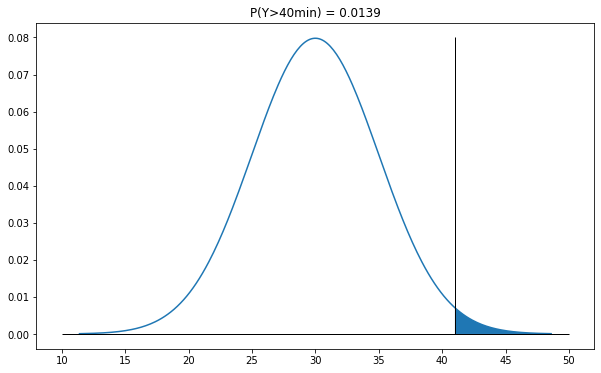

In [116]:
fig, ax = plt.subplots()

x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)
ax.plot(x, norm_rv.pdf(x))

ax.fill_between(x[x > 41], norm_rv.pdf(x[x > 41]), np.zeros(len(x[x > 41])))
p = 1 - norm_rv.cdf(41)
ax.set_title("P(Y>40min) = {:.3}".format(p))
ax.hlines(0, 10, 50, lw=1, color="k")
ax.vlines(41, 0, 0.08, color="k", lw=1);

Ok, let's imaging that we are on some island and we found out that average height of hobbits and gnomes in centimeters is distributed as $N(91;8^2)$ and $N(134;6^2)$ respectively. If Frodo's height is 99 centimeters and Gimli's is 143 centimeters then how to decided which height is more typical to their kinds? In order to find out we can plot function of distribution of probability density, mark their heights and measure portion of those whose height is higher than Frodo or Gimli.

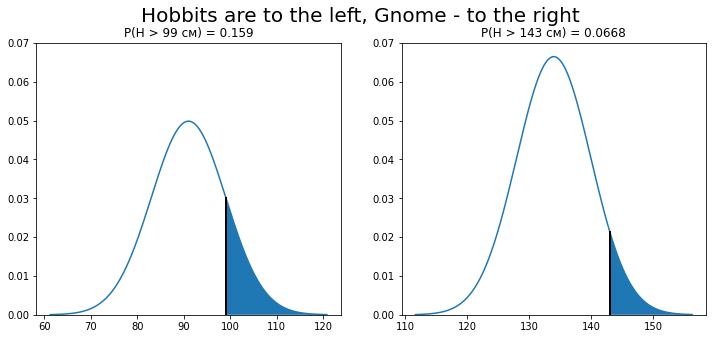

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

nrv_hobbit = stats.norm(91, 8)
nrv_gnome = stats.norm(134, 6)

for i, (func, h) in enumerate(zip((nrv_hobbit, nrv_gnome), (99, 143))):
    x = np.linspace(func.ppf(0.0001), func.ppf(0.9999), 300)
    ax[i].plot(x, func.pdf(x))
    ax[i].fill_between(x[x > h], func.pdf(x[x > h]), np.zeros(len(x[x > h])))
    p = 1 - func.cdf(h)
    ax[i].set_title("P(H > {} см) = {:.3}".format(h, p))
    ax[i].hlines(0, func.ppf(0.0001), func.ppf(0.9999), lw=1, color="k")
    ax[i].vlines(h, 0, func.pdf(h), color="k", lw=2)
    ax[i].set_ylim(0, 0.07)
fig.suptitle("Hobbits are to the left, Gnome - to the right", fontsize=20);

By looking at these charts we can assume that Frodo's height is more typical than Gimli's as it is closer to the pick of the distribution. That means that it's more likely to find hobbit with the height the same as Frodo than to meat a gnome with height the same as Gimli. That is what `typicality` means.

Performing comparison is much more easy if to use $Z$-values:

$$ Z_{Frodo} = \frac{99 - 91}{8} = 1 $$
$$ Z_{Gimli} = \frac{143 - 134}{6} = 1 $$

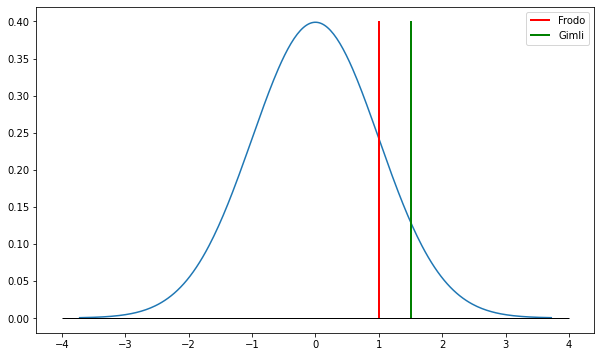

In [120]:
fig, ax = plt.subplots()
N_rv = stats.norm()
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, -4, 4, lw=1, color="k")
ax.vlines(1, 0, 0.4, color="r", lw=2, label="Frodo")
ax.vlines(1.5, 0, 0.4, color="g", lw=2, label="Gimli")
ax.legend();

Huge advantage of $Z$-values is that they are standardized, in other words they are transformed in such way like they are taken from normal distribution $N(0;1)$, both have mean of 0 and std of 1, that's why we were able to plot them at the same chart. 

Even without plotting chart we can find out which height is more typical by comparing absolute values:

$$ | Z_{Frodo} | < | Z_{Gimli} | $$

values with smaller absolute $Z$-value are more typical.

Comparison of multiple $Z$-values from multiple normal distributions is possible because $Z$-values are measured in $\sigma$ units. It becomes apparent when we take a look at the formula one more time:

$$ Z = \frac{y - \mu}{\sigma} $$

It doesn't matter what we are trying to compare: height, weight or income; whatever original units are, after calculating $Z$-values they are all will be measure in $\sigma$ units. The smaller absolute $Z$-value is the closer it is to the peak of the distribution and the sign of $Z$-value wil show to what side of this peak this value is located. 